# Image Registration

### Learning Objectives

* Understand how ITK does computations in physical space
* Understand why ITK does registration in physical space instead of pixel space
* Become familiar with the components of the ITK Registration Framework, and survey their possible values

## Overview
The content for this section is provided as a separate presentation [GDocs](https://docs.google.com/presentation/d/1mVMd2hd73gkoGoIYO47EW7iiBiCKFGiUo43fzxbmyUc/edit?usp=sharing) [pdf](https://data.kitware.com/api/v1/file/5c88e7ea8d777f072b9443f6/download?contentDisposition=inline).

## Exercise 1: Transforms and Pixels

![Transforms and pixels](data/transforms-and-pixels.png)


## Exercise 2: Components of the registration framework

Study the image registration pipeline below, and replace the `fixMe` the components with their correct values.


In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

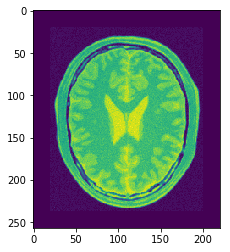

In [2]:
PixelType = itk.ctype('float')

fixedImage = itk.imread('data/BrainProtonDensitySliceBorder20.png', PixelType)
plt.imshow(itk.array_view_from_image(fixedImage))

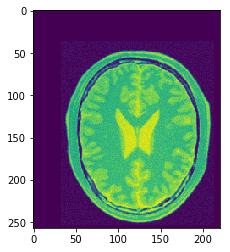

In [3]:
movingImage = itk.imread('data/BrainProtonDensitySliceShifted13x17y.png', PixelType)

plt.imshow(itk.array_view_from_image(movingImage))

In [4]:
Dimension = fixedImage.GetImageDimension()
FixedImageType = type(fixedImage)
MovingImageType = type(movingImage)

TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200)

metric = itk.MeanSquaresImageToImageMetricv4[
    FixedImageType, MovingImageType].New()

In [ ]:
registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixMe,
        MovingImage=fixMe,
        Metric=fixMe,
        Optimizer=fixMe,
        InitialTransform=fixMe)

In [11]:
# %load solutions/5_Registration_Exercise2Answer1.py

In [ ]:
movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

identityTransform = TransformType.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

registration.Update()

In [12]:
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

Result = 
 Translation X = 13.00123653240422
 Translation Y = 16.999943471681494
 Iterations    = 22
 Metric value  = 0.0006793961893802234


In [13]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

In [ ]:
resampler = itk.ResampleImageFilter.New(Input=fixMe,
        Transform=fixMe,
        UseReferenceImage=True,
        ReferenceImage=fixMe)

In [ ]:
# %load solutions/5_Registration_Exercise2Answer2.py

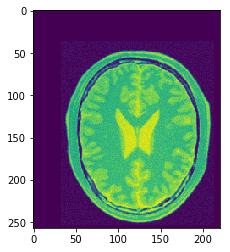

In [17]:
resampler.SetDefaultPixelValue(100)

OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, Dimension]

resampler.Update()

plt.imshow(itk.array_view_from_image(movingImage))

In [20]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage,
        Input2=resampler)
resampler.SetDefaultPixelValue(1)

difference.Update()
view(difference.GetOutput())

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [21]:
resampler.SetTransform(identityTransform)
difference.Update()

view(difference.GetOutput())

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

## Exercise 3: Image similarity matching metrics

Examine the available [registration framework image similarity matching metrics](https://itk.org/Doxygen/html/classitk_1_1ImageToImageMetricv4.html).

- Can an alternative metric be used in the registration pipeline above?
- Which metrics should be used for multi-modality registration?

## Exercise 4: Multi-modality registration

![dzCBCT and dzTMJ](data/dzIntensities.png)


In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

Pixel spacing: itkVectorD2 ([1, 1])


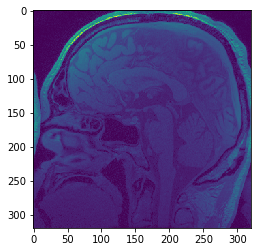

In [2]:
mrPNG = itk.imread('data/dzTMJ.png', itk.UC) # range 0-255
print("Pixel spacing:", mrPNG.GetSpacing()) # pixel size information lost
plt.imshow(itk.array_view_from_image(mrPNG))

Pixel spacing: itkVectorD2 ([0.6, 0.6])


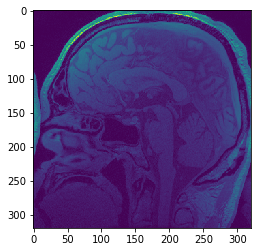

In [3]:
mrNRRD = itk.imread('data/dzTMJ.nrrd', itk.F) # range 0 to 1530
print("Pixel spacing:", mrNRRD.GetSpacing()) # pixel size information retained
plt.imshow(itk.array_view_from_image(mrNRRD))

Pixel spacing: itkVectorD2 ([1, 1])


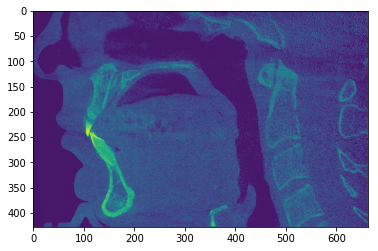

In [4]:
ctPNG = itk.imread('data/dzCBCT.png', itk.UC) # range 0-255
print("Pixel spacing:", ctPNG.GetSpacing()) # pixel size information lost
plt.imshow(itk.array_view_from_image(ctPNG))

Pixel spacing: itkVectorD2 ([0.25, 0.25])
Direction matrix:
 [[-1.  0.]
 [ 0. -1.]]


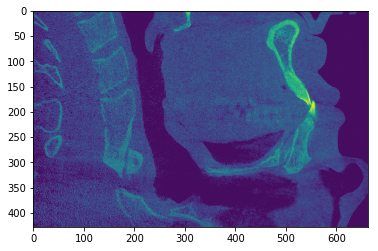

In [5]:
ctNRRD = itk.imread('data/dzCBCT.nrrd', itk.F) # range -1150 to 3178
print("Pixel spacing:", ctNRRD.GetSpacing()) # pixel size information retained
plt.imshow(itk.array_view_from_image(ctNRRD)) # ignores direction matrix so image looks inverted

pyDirM=itk.GetArrayFromVnlMatrix(ctNRRD.GetDirection().GetVnlMatrix().as_matrix())
print("Direction matrix:\n", pyDirM)

In [6]:
# print(ctNRRD) # a lot of information about the image including direction matrix
view(ctNRRD) # metadata respected so image looks correct

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [17]:
CTImageType = type(ctNRRD)
MRImageType = type(mrNRRD)
assert CTImageType==MRImageType, "Images must have the same pixel type!"

TransformTypeR = itk.Rigid2DTransform[itk.D]
initialTransform = TransformTypeR.New()

MetricType = itk.MattesMutualInformationImageToImageMetricv4[
        MRImageType, CTImageType]
metric = MetricType.New()

scales = itk.OptimizerParameters[itk.D](initialTransform.GetNumberOfParameters())
scales.SetElement(0, 1.0)
scales.SetElement(1, 100.0)
scales.SetElement(2, 100.0)

optimizer = itk.GradientDescentOptimizerv4Template.New(
        Scales=scales,
        ReturnBestParametersAndValue=True,
        NumberOfIterations=200)

registration = itk.ImageRegistrationMethodv4.New(FixedImage=mrNRRD,
        MovingImage=ctNRRD,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform)

initialParameters = initialTransform.GetParameters()

In [15]:
# fixMe: set initial parameters which result in converging registration
# this is the solution
initialParameters[0] = 0.107 # rotation in radians
initialParameters[1] = 50.0 # x translation in millimeters
initialParameters[2] = -80.0 # y translation in millimeters
initialTransform.SetParameters(initialParameters)

resampler = itk.ResampleImageFilter.New(Input=ctNRRD,
        Transform=initialTransform,
        UseReferenceImage=True,
        ReferenceImage=mrNRRD)
resampler.SetDefaultPixelValue(-1000)
resampler.Update()

# initial position of CT image when resampled into MR image's pixel grid
viewer = view(resampler.GetOutput(), ui_collapsed=True, annotations=False)
import ipywidgets as widgets
viewer2 = view(mrNRRD, ui_collapsed=True, annotations=False)
widgets.HBox([viewer, viewer2])

In [22]:
registration.SetMovingInitialTransform(initialTransform)

Dimension = mrNRRD.GetImageDimension()
identityTransform = TransformTypeR.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

try:
    registration.Update()
except RuntimeError as exc:
    print("Exception ocurred:\n", exc, "\n\n")
finally:
    print("Registration finished")
    
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(initialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())
    
resamplerResult = itk.ResampleImageFilter.New(Input=ctNRRD,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=mrNRRD)
resamplerResult.SetDefaultPixelValue(-1000)
resamplerResult.Update()
view(resamplerResult.GetOutput()) # final position of CT image when resampled into MR image's pixel grid

Registration finished


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [23]:
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
rotationInDegrees = finalParameters.GetElement(0) / 3.141592*180
translationAlongX = finalParameters.GetElement(1)
translationAlongY = finalParameters.GetElement(2)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

print("Result = ")
print(" Rotation degr = " + str(rotationInDegrees))
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

difference = itk.AddImageFilter.New(Input1=mrNRRD,
        Input2=resamplerResult)
difference.Update()
view(difference.GetOutput())

Result = 
 Rotation degr = -0.5452500015657596
 Translation X = -0.0006264038750333859
 Translation Y = -7.335580118316311e-05
 Iterations    = 52
 Metric value  = -0.09728190795932262


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

## Enjoy ITK!